In [94]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tpot import TPOTClassifier

import sklearn

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split

## Data import

In [20]:
# Data Read
df_train = pd.read_csv('../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_train.csv')
df_test = pd.read_csv('../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_test.csv')

# Compare Columns to Desc
print(df_test.columns)
print(df_train.columns)

Index(['Unnamed: 0', 'age', 'race', 'earnwke', 'married', 'union', 'ne_states',
       'so_states', 'ce_states', 'we_states', 'government', 'private', 'self',
       'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac',
       'educ_adv', 'female'],
      dtype='object')
Index(['Unnamed: 0', 'age', 'race', 'earnwke', 'employed', 'unemployed',
       'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states',
       'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol',
       'educ_aa', 'educ_bac', 'educ_adv', 'female'],
      dtype='object')


## Data exploration

In [21]:
# First Look at the data


train = df_train.values
train_ids = train[:, 0]
train_employed = train[:, 4]
train_unemployed = train[:, 5]
train_data = train[:,np.array([not i == 4 and  not i == 5  for i in range(1,23)])]
test = df_test.values 

print("Amount of entries and features of training data:", train.shape)
print("Amount of entries:", train_ids.shape)
print("Entry count for employed classification:",train_employed.shape)
print("Amount of entries and features of testing data:", train_data.shape)
print("Amount of entries and features for the final testing data:", test.shape)

print("Amount of missing values: ", df_train.isnull().sum())
## only values which are "zero" are for those who have no weekly income which seems logical in regard to employment

print(df_train.describe())

Amount of entries and features of training data: (5212, 22)
Amount of entries: (5212,)
Entry count for employed classification: (5212,)
Amount of entries and features of testing data: (5212, 20)
Amount of entries and features for the final testing data: (200, 20)
Amount of missing values:  Unnamed: 0        0
age               0
race              0
earnwke         605
employed          0
unemployed        0
married           0
union             0
ne_states         0
so_states         0
ce_states         0
we_states         0
government        0
private           0
self              0
educ_lths         0
educ_hs           0
educ_somecol      0
educ_aa           0
educ_bac          0
educ_adv          0
female            0
dtype: int64
        Unnamed: 0          age         race     employed   unemployed  \
count  5212.000000  5212.000000  5212.000000  5212.000000  5212.000000   
mean   2701.044321    42.123177     1.226401     0.889870     0.040292   
std    1566.134437    11.358779   

In [22]:
for i in range(0,len(train_employed)):
    print(train_employed[i],train_unemployed[i])

1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
0 1
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
0 1
0 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 1
0 1
1 0
1 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 1
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0


In [23]:
#Comparing of employed & unemployed for nonsensical data
ctr= 0
for i in range(0, len(train_employed)):
    if train_employed[i] == train_unemployed[i]:
        print(i, train_employed[i],train_unemployed[i])
        ctr+=1
print(ctr)


7 0 0
18 0 0
34 0 0
92 0 0
103 0 0
116 0 0
123 0 0
127 0 0
135 0 0
141 0 0
158 0 0
167 0 0
175 0 0
225 0 0
240 0 0
256 0 0
269 0 0
275 0 0
308 0 0
326 0 0
327 0 0
342 0 0
353 0 0
366 0 0
375 0 0
383 0 0
403 0 0
422 0 0
426 0 0
427 0 0
434 0 0
440 0 0
441 0 0
467 0 0
479 0 0
484 0 0
524 0 0
545 0 0
550 0 0
569 0 0
585 0 0
598 0 0
604 0 0
660 0 0
681 0 0
700 0 0
714 0 0
716 0 0
748 0 0
765 0 0
766 0 0
768 0 0
802 0 0
803 0 0
804 0 0
815 0 0
839 0 0
860 0 0
869 0 0
878 0 0
886 0 0
887 0 0
890 0 0
891 0 0
932 0 0
956 0 0
973 0 0
983 0 0
996 0 0
1055 0 0
1064 0 0
1107 0 0
1117 0 0
1118 0 0
1152 0 0
1206 0 0
1251 0 0
1263 0 0
1276 0 0
1313 0 0
1335 0 0
1341 0 0
1372 0 0
1373 0 0
1388 0 0
1397 0 0
1403 0 0
1428 0 0
1444 0 0
1457 0 0
1464 0 0
1489 0 0
1491 0 0
1517 0 0
1533 0 0
1557 0 0
1599 0 0
1604 0 0
1619 0 0
1643 0 0
1659 0 0
1664 0 0
1665 0 0
1675 0 0
1681 0 0
1683 0 0
1695 0 0
1739 0 0
1740 0 0
1762 0 0
1765 0 0
1831 0 0
1844 0 0
1867 0 0
1876 0 0
1897 0 0
1920 0 0
1928 0 0
1938 0 0
195

Notes: 

<s>Current understanding is that employed & unemployed are NOT exclusive</s>

After contemplation certain sets do not make sense, therefore I will remove such nonsensical data entries
 

## Encoding & Train Test Split

In [24]:
#No encoding since gender, employment status, educ, states and such are already encoded

#Splitting
temp_train_ids, temp_test_ids, temp_train_data, temp_test_data, temp_train_employed, temp_test_employed = train_test_split(train_ids, train_data, train_employed, test_size=50, random_state=4)

## Preprocessing the data 

In [53]:
snv = sklearn.preprocessing.StandardScaler()
prep_temp_train_data = snv.fit_transform(temp_train_data)
prep_temp_test_data = snv.transform(temp_test_data)


## Data visualization 

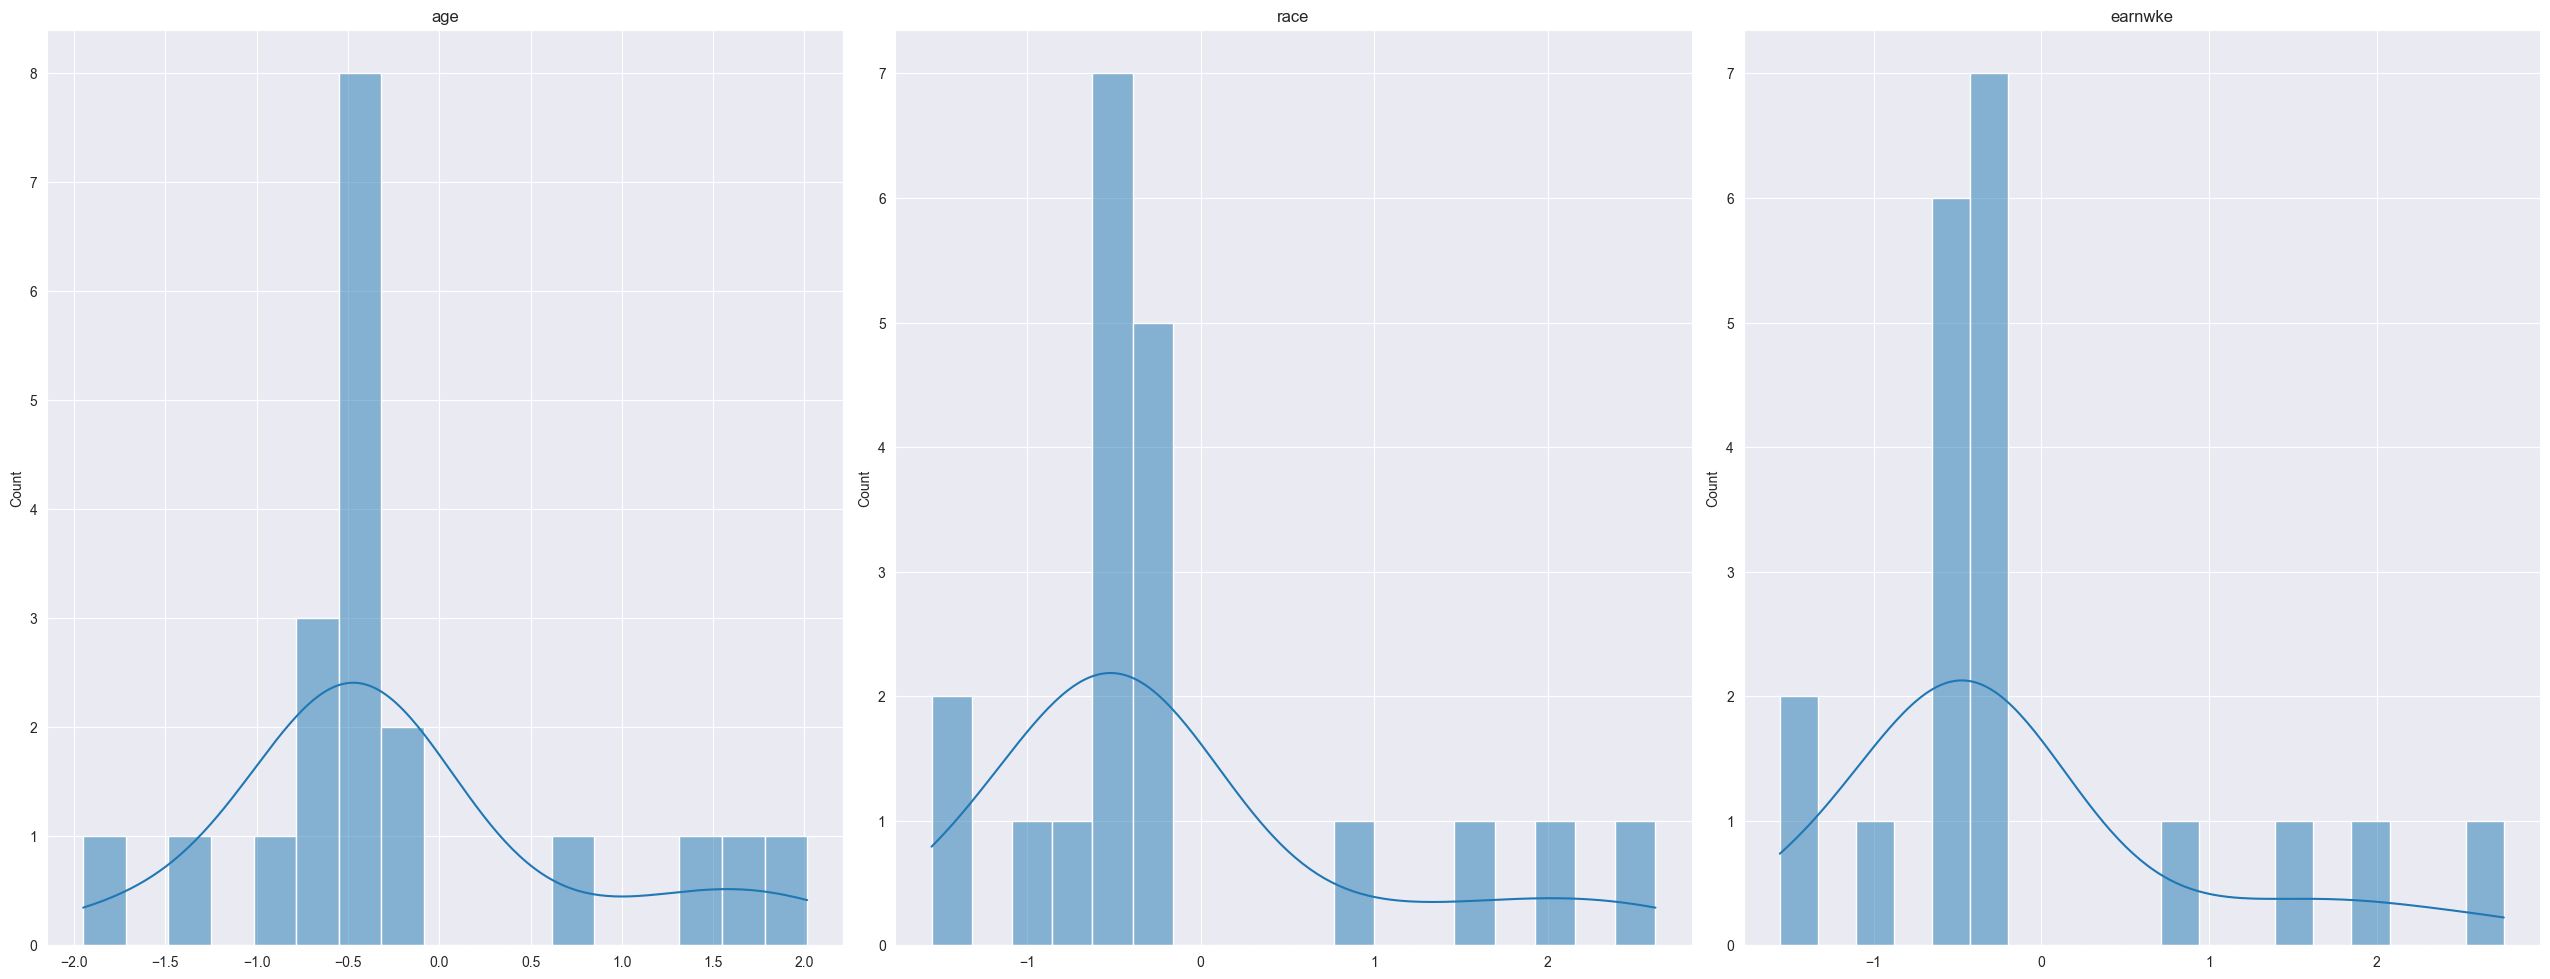

In [52]:
## Temporäre Ergänzung zur besseren Teambesprechung 

# Data Visualization
# Plot histograms for continuous variables

continuous_cols = ['age', 'race', 'earnwke']

j = 0
plt.figure(figsize=(25.6, 19.2))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)#2, 3, i
    if col in continuous_cols: sns.histplot(prep_temp_train_data[j], kde=True)
    plt.title(col)
    j +=1
plt.tight_layout()
plt.show()

# Plot count plots for categorical variables
categorical_cols = ['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']

#j = 0
#plt.figure(figsize=(25.6, 19.2))
#for i, col in enumerate(categorical_cols, 1):
#    plt.subplot()#4, 3, i
#    if col in categorical_cols:sns.countplot(data=prep_temp_train_data, x=j)
#    plt.title(col)
#    j +=1    
#plt.tight_layout()
#plt.show()


In [65]:
#train_partial = train[:, 1:5]
#df_cols = ['age', 'race', 'earnwke', 'employed']
#traind_df = pd.DataFrame([{'age':train_partial[:,0], 'race':train_partial[:,1], 'earnwke':train_partial[:,2], 'employed':train_partial[:,3]}])


#sns.pairplot(traind_df, hue ='employed')
#plt.suptitle('Pair Plot of continous features by deny (target variable)', y=1.02)
#plt.show()

In [79]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

KNeighborsClassifier()

In [83]:
temp_test_employed_pred = knn_classifier.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.94
F1-Score 0.9690721649484536


In [89]:
gaussian_process_classifier = GaussianProcessClassifier()
gaussian_process_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

GaussianProcessClassifier()

In [90]:
temp_test_employed_pred = gaussian_process_classifier.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.92
F1-Score 0.9583333333333334


In [91]:
svc = SVC()#kernel='linear'
svc.fit(prep_temp_train_data, temp_train_employed.astype(bool))

SVC()

In [92]:
temp_test_employed_pred = svc.predict(prep_temp_test_data)

print("Accuracy",sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_employed_pred))
print("F1-Score",sklearn.metrics.f1_score (temp_test_employed.astype(bool), temp_test_employed_pred))

Accuracy 0.94
F1-Score 0.9690721649484536


In [101]:
def hyperparameter_function_svc(gamma, C):
    """ Function for hyperparameter optimization
    """
    svc = SVC(gamma=gamma, C=C)
    svc.fit(prep_temp_train_data, temp_train_employed.astype(bool))
    temp_test_balance_pred = svc.predict(prep_temp_test_data)
    return - sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_balance_pred)

# Bounded region of parameter space
pbounds = {'gamma': (0, 1.5), 'C': (0.00001, 2)}

optimizer = BayesianOptimization(
    f=hyperparameter_function_svc,
    pbounds=pbounds,
    random_state=6,
)

In [102]:
optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | -0.92     | 1.786     | 0.498     |
| 2         | -0.94     | 1.642     | 0.06254   |
| 3         | -0.94     | 0.2153    | 0.8926    |
| 4         | -0.92     | 1.06      | 0.6282    |
| 5         | -0.92     | 0.6708    | 0.9338    |
| 6         | -0.92     | 0.8763    | 1.104     |
| 7         | -0.92     | 1.036     | 0.8683    |
| 8         | -0.9      | 1.291     | 1.485     |
| 9         | -0.92     | 1.64      | 0.6198    |
| 10        | -0.9      | 1.753     | 1.236     |
| 11        | -0.94     | 0.109     | 1.078     |
| 12        | -0.9      | 1.604     | 1.105     |
| 13        | -0.92     | 1.418     | 0.8114    |
| 14        | -0.94     | 0.2497    | 1.436     |
| 15        | -0.94     | 0.8065    | 0.3254    |
| 16        | -0.9      | 1.435     | 1.491     |
| 17        | -0.94     | 0.5112    | 1.007     |
| 18        | -0.92     | 1.198     | 1.076     |


In [ ]:
svc = sklearn.svm.SVC(gamma=2, C=0.3817)
svc.fit(prep_temp_train_data, temp_train_employed)
temp_test_balance_pred = svc.predict(prep_temp_test_data)

print(sklearn.metrics.mean_absolute_error(temp_test_employed, temp_test_balance_pred))

In [106]:
random_forest_classifier = RandomForestClassifier(n_estimators=40, random_state=6)
random_forest_classifier.fit(prep_temp_train_data, temp_train_employed.astype(bool))

RandomForestClassifier(n_estimators=40, random_state=6)

In [109]:
temp_test_balance_pred = random_forest_classifier.predict(prep_temp_test_data)

print(sklearn.metrics.accuracy_score(temp_test_employed.astype(bool), temp_test_balance_pred))

0.92
